1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np
from torch.nn import functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
print(torchvision.__version__)

0.8.2+cu101


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
type(trainset.data)

numpy.ndarray

In [9]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
type(trainset.targets)

list

In [12]:
print('Original dataset shape %s' % collections.Counter(trainset.targets))


Original dataset shape Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [13]:
class unbalance_CIFAR10(CIFAR10):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_CIFAR10, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        

     
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 50,
                1: 5000,
                2: 50,
                3: 5000,
                4: 50,
                5: 5000,
                6: 50,
                7: 5000,
                8: 50,
                9: 5000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(50000,32*32*3), np.array(self.targets))
#         self.data, self.targets = torch.Tensor(self.data.reshape(-1,32,32,3)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)
        self.data, self.targets = self.data.reshape(-1,32,32,3), self.targets



In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 5000, 3: 5000, 5: 5000, 7: 5000, 9: 5000, 0: 50, 2: 50, 4: 50, 6: 50, 8: 50})


In [16]:
type(trainset.data)

numpy.ndarray

In [17]:
type(testset.data)

numpy.ndarray

In [18]:
trainset.data.shape

(25250, 32, 32, 3)

In [19]:
type(trainset.targets)

numpy.ndarray

In [20]:
len(trainset.data)

25250

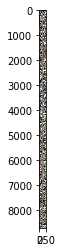

  dog   car   dog   cat


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [23]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [24]:
#torch 를 이용해서 재구성하기, for문을 사용하면 느려질 수 밖에 없음

In [25]:
def custom_FL_tensor(output,labels, alpha=1, gamma=10):
    logpt = F.log_softmax(output, 1)
    logpt = logpt.gather(1, labels.unsqueeze(1))
    logpt = logpt.view(-1)
    pt = logpt.exp()
    loss = -1*alpha*((1-pt)**gamma)*logpt
    loss = loss.mean()
    return loss

In [26]:
import time
start = time.time()  # 시작 시간 저장

In [27]:
net.train()
for epoch in range(600):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = custom_FL_tensor(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.438
[2,    10] loss: 0.169
[3,    10] loss: 0.113
[4,    10] loss: 0.093
[5,    10] loss: 0.082
[6,    10] loss: 0.075
[7,    10] loss: 0.067
[8,    10] loss: 0.061
[9,    10] loss: 0.053
[10,    10] loss: 0.049
[11,    10] loss: 0.046
[12,    10] loss: 0.041
[13,    10] loss: 0.036
[14,    10] loss: 0.032
[15,    10] loss: 0.029
[16,    10] loss: 0.026
[17,    10] loss: 0.024
[18,    10] loss: 0.021
[19,    10] loss: 0.019
[20,    10] loss: 0.017
[21,    10] loss: 0.017
[22,    10] loss: 0.015
[23,    10] loss: 0.014
[24,    10] loss: 0.013
[25,    10] loss: 0.012
[26,    10] loss: 0.011
[27,    10] loss: 0.010
[28,    10] loss: 0.009
[29,    10] loss: 0.009
[30,    10] loss: 0.008
[31,    10] loss: 0.008
[32,    10] loss: 0.007
[33,    10] loss: 0.006
[34,    10] loss: 0.007
[35,    10] loss: 0.007
[36,    10] loss: 0.006
[37,    10] loss: 0.006
[38,    10] loss: 0.005
[39,    10] loss: 0.005
[40,    10] loss: 0.005
[41,    10] loss: 0.005
[42,    10] loss: 0.005
[

[334,    10] loss: 0.001
[335,    10] loss: 0.001
[336,    10] loss: 0.001
[337,    10] loss: 0.001
[338,    10] loss: 0.001
[339,    10] loss: 0.001
[340,    10] loss: 0.001
[341,    10] loss: 0.002
[342,    10] loss: 0.002
[343,    10] loss: 0.002
[344,    10] loss: 0.002
[345,    10] loss: 0.001
[346,    10] loss: 0.001
[347,    10] loss: 0.001
[348,    10] loss: 0.001
[349,    10] loss: 0.001
[350,    10] loss: 0.001
[351,    10] loss: 0.001
[352,    10] loss: 0.001
[353,    10] loss: 0.002
[354,    10] loss: 0.001
[355,    10] loss: 0.001
[356,    10] loss: 0.001
[357,    10] loss: 0.001
[358,    10] loss: 0.001
[359,    10] loss: 0.001
[360,    10] loss: 0.001
[361,    10] loss: 0.001
[362,    10] loss: 0.001
[363,    10] loss: 0.001
[364,    10] loss: 0.001
[365,    10] loss: 0.001
[366,    10] loss: 0.000
[367,    10] loss: 0.001
[368,    10] loss: 0.000
[369,    10] loss: 0.000
[370,    10] loss: 0.000
[371,    10] loss: 0.000
[372,    10] loss: 0.000
[373,    10] loss: 0.000


In [28]:
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1207.1063017845154


In [29]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:   frog  frog  ship  ship horse  frog   car   dog  ship  bird   cat  bird truck  ship  ship  bird plane truck  bird  bird   car horse  frog  deer   dog horse  deer plane   car   dog  bird  bird plane horse  ship   car plane plane   car  bird  deer plane   cat horse   dog   dog truck plane plane  frog  bird  frog  ship plane  deer  frog  frog plane   dog  deer   dog  frog   cat  ship


In [31]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [32]:
net.train()
outputs = net(images)

In [33]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    dog   cat   car   dog horse   dog   car   dog truck   cat horse   dog   car   car truck truck truck truck horse horse   car horse   cat   dog   dog   dog horse plane truck   dog   cat horse truck horse truck   car truck truck   car   dog horse horse   cat horse   dog   dog truck truck truck   cat   cat  frog   cat truck horse   cat horse truck   dog horse   dog truck   cat   car truck   cat   car   dog horse   dog truck truck   cat   cat truck truck   dog   cat   cat horse horse   dog   cat horse   car horse   dog truck   cat truck horse   cat   cat   car   car   car   cat   cat   dog plane   dog   dog   car   cat truck   cat   dog horse   cat   dog   cat   dog   dog   car   car truck   dog horse horse   car   car   dog truck   car   cat   dog horse   dog truck truck   dog   car   car   cat   cat   cat   dog truck   car   cat truck   cat   dog   cat   dog   car   dog   cat   car horse truck truck   car horse   car   dog   cat   dog   dog   cat   dog   dog truck   car   do

In [34]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


In [35]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 17.7 %
Accuracy for class car   is: 84.9 %
Accuracy for class bird  is: 2.1 %
Accuracy for class cat   is: 67.7 %
Accuracy for class deer  is: 3.6 %
Accuracy for class dog   is: 70.8 %
Accuracy for class frog  is: 10.9 %
Accuracy for class horse is: 80.9 %
Accuracy for class ship  is: 8.2 %
Accuracy for class truck is: 90.4 %


In [36]:
for i in range(10):
    print(classes[labels[i]])

cat
horse
bird
truck
deer
cat
horse
deer
deer
bird
